In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas, numpy, random
import matplotlib.pyplot as plt

In [2]:
# if CUDA is available, use GPU and set default tensor type to cuda

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: GeForce RTX 2080 Ti


device(type='cuda')

In [3]:
max_length_smiles = 30
input_para = 200

class Token(nn.Embedding):
    def __init__(self, vocab_size, embed_size=200, padding_idx=0):
        super().__init__(vocab_size, embed_size, padding_idx)
        
token = Token(30)

def convertToASCII(item):
    ascii = []
    for char in item:
        ascii.append(ord(char))
        
    return ascii

In [4]:
# dataset class

class qm9Dataset(Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None, skiprows=1, dtype='unicode')
        #print(self.data_df)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        smiles = (self.data_df.iloc[index,0] + " " * max_length_smiles)[0:max_length_smiles]
        smiles = torch.cuda.FloatTensor(convertToASCII(smiles)) / 128.0   #ascii max value
        
        labels = []
        labels.append(float(self.data_df.iloc[index,1]))
        labels.append(float(self.data_df.iloc[index,2]))
        labels.append(float(self.data_df.iloc[index,3]))
        labels.append(float(self.data_df.iloc[index,4]))
        labels.append(float(self.data_df.iloc[index,5]))
        labels.append(float(self.data_df.iloc[index,6]))
        labels.append(float(self.data_df.iloc[index,7]))
        labels.append(float(self.data_df.iloc[index,8]))
        labels.append(float(self.data_df.iloc[index,9]))
        labels.append(float(self.data_df.iloc[index,10]))
        labels.append(float(self.data_df.iloc[index,11]))
        labels.append(float(self.data_df.iloc[index,11]))
        labels.append(float(self.data_df.iloc[index,12]))
        
        labels = torch.cuda.FloatTensor(labels)
        
        target = torch.zeros((len(self.data_df))).to(device)
        target[index] = 1.0
        
        return smiles,labels,target
    
    pass

In [5]:
qm9dataset = qm9Dataset('dataset/qm9.csv')

In [6]:
qm9dataset[2]

(tensor([0.6172, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
         0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
         0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
         0.2500, 0.2500, 0.2500]),
 tensor([ 1.8511e+00,  6.3100e+00, -2.9280e-01,  6.8700e-02,  3.6150e-01,
          1.9000e+01,  2.1375e-02,  6.0020e+00, -7.6405e+01, -7.6402e+01,
         -7.6401e+01, -7.6401e+01, -7.6422e+01]),
 tensor([0., 0., 1.,  ..., 0., 0., 0.]))

In [7]:
from torch.utils.data import DataLoader
data_loader = torch.utils.data.DataLoader(qm9dataset,batch_size=1,shuffle=False)

'''
max_length_smiles = 0
i = 0
for smiles,label,target in data_loader:
    i += 1
    if (i % 1000 == 0):
        print(smiles)
    max_length_smiles = max(max_length_smiles, len(smiles[0]))
    #print("Max length smiles:", max_length_smiles)

    #max_length_smiles = 29
'''

'\nmax_length_smiles = 0\ni = 0\nfor smiles,label,target in data_loader:\n    i += 1\n    if (i % 1000 == 0):\n        print(smiles)\n    max_length_smiles = max(max_length_smiles, len(smiles[0]))\n    #print("Max length smiles:", max_length_smiles)\n\n    #max_length_smiles = 29\n'

In [8]:
def generate_random_smiles(size):
    random_data = torch.randint(0, 128, (1,size))/128
    return random_data.float()

def generate_random_one_hot(size):
    label_tensor = torch.zeros((size))
    random_idx = random.randint(0,size-1)
    label_tensor[random_idx] = 1.0
    return label_tensor

def generate_random_seed(size):
    random_data = torch.randint(0, 128, (1,size))/128
    #torch.randn(size)
    return random_data


class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)
    
generate_random_smiles(max_length_smiles)    

tensor([[0.6094, 0.8438, 0.5000, 0.2188, 0.3672, 0.6250, 0.5312, 0.4141, 0.5703,
         0.3047, 0.2031, 0.3750, 0.6406, 0.5625, 0.7891, 0.3672, 0.9844, 0.4922,
         0.3828, 0.0156, 0.7422, 0.3281, 0.0547, 0.5391, 0.7969, 0.4688, 0.5859,
         0.8203, 0.0000, 0.1562]])

In [9]:
# dragan
# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            View(max_length_smiles),
            
            #nn.Linear(30, 100),
            #nn.LeakyReLU(),
            
            #nn.LayerNorm(100),
            
            #nn.Linear(100, 1),
            #nn.Sigmoid()
            
            
            nn.Linear(max_length_smiles, 200),
            nn.Sigmoid(),
            nn.Linear(200,1),
            nn.Sigmoid()
            
        )
        
        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # combine seed and label
        #inputs = torch.cat((image_tensor, label_tensor))
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        #print("outputs", outputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [10]:
%%time
# test discriminator can separate real data from random noise


D = Discriminator()
D.to(device)

for smiles,label,target in data_loader:
    # real
    #print("smiles.shape", smiles.shape)
    D.train(smiles, torch.cuda.FloatTensor([1.0]))
    # fake
    D.train(generate_random_smiles(max_length_smiles), torch.cuda.FloatTensor([0.0]))
    pass


counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
counter =  250000
counter =  260000
CPU times: user 6min 59s, sys: 6.82 s, total: 7min 5s
Wall time: 7min 3s


In [20]:
for i in range(4):
    #random.randint(0,20000)
    data_tensor,_,_ = qm9dataset[random.randint(0,130000)]
    print( D.forward( data_tensor ).item() )
    pass

for i in range(4):
    print( D.forward(generate_random_smiles(max_length_smiles)).item() )
    pass

0.4992969334125519
0.5011580586433411
0.5011780261993408
0.5016878843307495
0.4956660866737366
0.4923086166381836
0.5017532706260681
0.4985238015651703


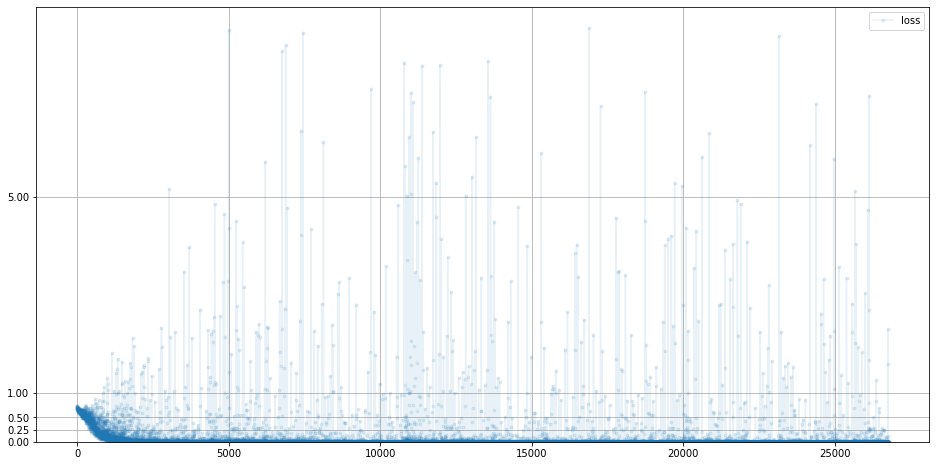

In [13]:
D.plot_progress()

In [14]:
class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            #nn.Linear(input_para, 200),
            #nn.LeakyReLU(0.02),
            #nn.ReLU(),

            #nn.LayerNorm(200),

            #nn.Linear(200, max_length_smiles),
            #nn.Sigmoid()
            
            
            nn.Linear(input_para, 200),
            nn.Sigmoid(),
            nn.Linear(200, max_length_smiles),
            nn.Sigmoid()
            
        )
        
        # create optimiser, simple stochastic gradient descent
        #self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        return self.model(inputs)


    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [15]:
G = Generator()
G.to(device)

output = G.forward(generate_random_seed(input_para))

print("output", output)


output tensor([[0.3817, 0.5763, 0.4659, 0.6097, 0.4763, 0.4279, 0.4799, 0.5413, 0.5654,
         0.5743, 0.5858, 0.5499, 0.4997, 0.5802, 0.5298, 0.4074, 0.4623, 0.4602,
         0.4971, 0.5724, 0.4879, 0.4825, 0.5858, 0.6217, 0.5138, 0.5849, 0.2931,
         0.5150, 0.5785, 0.4316]], grad_fn=<SigmoidBackward>)


In [16]:
%%time 
D = Discriminator()
D.to(device)

G = Generator()
G.to(device)

epochs = 20
#epochs = 1

for epoch in range(epochs):
    print ("epoch = ", epoch + 1)

    # train Discriminator and Generator
    for smiles,label,target in data_loader:
        # train discriminator on true
        D.train(smiles, torch.cuda.FloatTensor([1.0]))

        # train discriminator on false
        # use detach() so gradients in G are not calculated
        D.train(G.forward(generate_random_seed(input_para)).detach(), torch.cuda.FloatTensor([0.0]))
        # train generator
        G.train(D, generate_random_seed(input_para), torch.cuda.FloatTensor([1.0]))

    pass
    
pass

epoch =  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
counter =  250000
counter =  260000
CPU times: user 14min 29s, sys: 13.9 s, total: 14min 43s
Wall time: 14min 38s


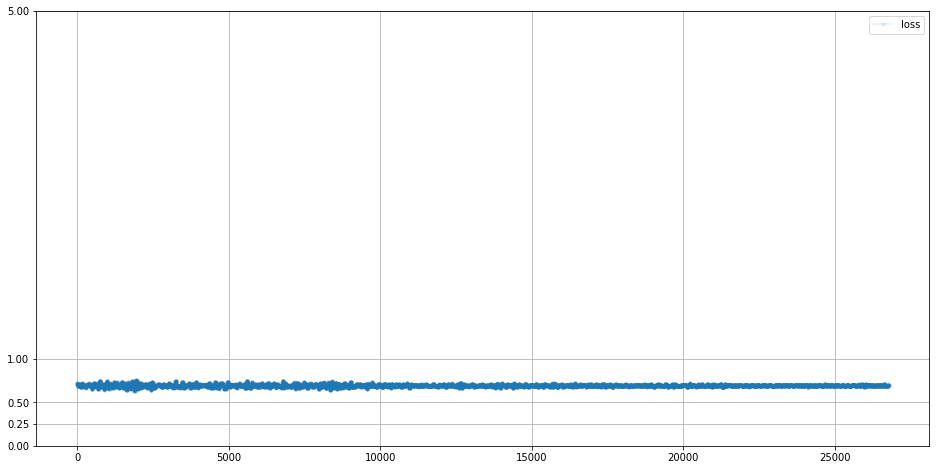

In [17]:
D.plot_progress()

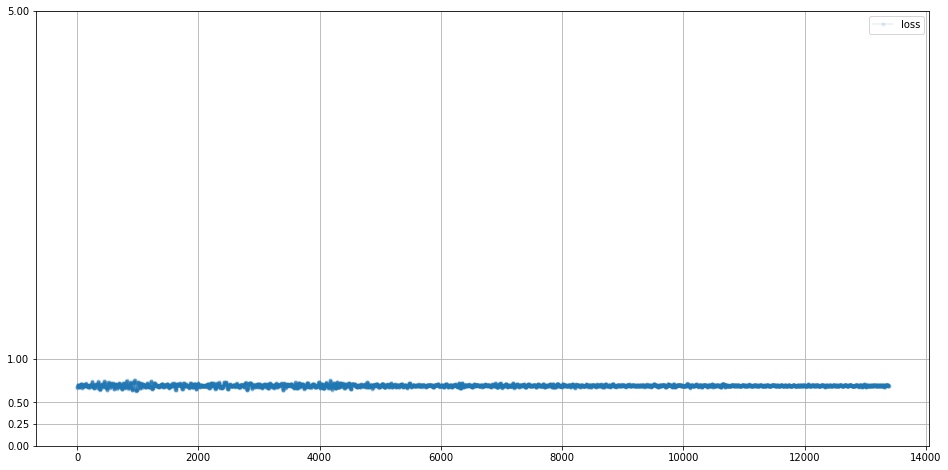

In [18]:
G.plot_progress()

In [19]:
for i in range(100):
    output = G.forward(generate_random_seed(input_para))
    smiles = output.detach().cpu().numpy()
    print("smiles:", smiles.astype(int) )           
    pass


smiles: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
smiles: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
smiles: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
smiles: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
smiles: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
smiles: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
smiles: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
smiles: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
smiles: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
smiles: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
smiles: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
smiles: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
smiles: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
smiles: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 